In [1]:
from photonic_circuit import Circuit
from optical_elements import BS, DFT, SwapOut, I
from states import PhotonicState, QuditState

## Example: qudit bell state version 3
just to show the gist of how to use this simulator, let's look at how to simulate the version 3 qudit bell state generator

(<Figure size 318.528x345.6 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1915c31c160>)

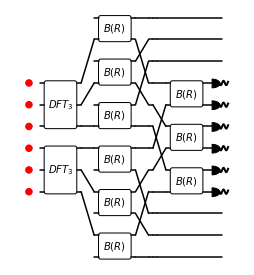

In [2]:
d = 3 # qudit dimension

# Circuit class holds information about the input state, 
# the optics of the circuit and where the detectors go
circuit = Circuit() 

# for the visualisation to work, you want to define things in the order they appear in the circuit,
# so input state first, then optical components, then detectors

### define input state ###
# here we want single photons in all modes from d to 3*d-1
circuit.add_input_photons(range(d,3*d))

### define optical circuit ###

# each 'OpticalElement' class (i.e. DFT, BS...) takes arguements to define it's transformation
# and an additional arguement 'offset' which defines the first mode which this element will act on
# if offset is not specified the element will appear directly below the previous element

circuit.add_optical_elements(DFT(d,offset=d), DFT(d))
circuit.add_optical_elements(SwapOut(d,2), SwapOut(d,2))
circuit.add_optical_elements(*[BS((d-1)/d)]*2*d)
circuit.add_optical_elements(SwapOut(2,d), SwapOut(2,d))
circuit.add_optical_elements(SwapOut(d,2,offset=d))
circuit.add_optical_elements(I(d), *[BS(0.5)]*d, I(d))

### define position of detectors ###
circuit.add_detectors(range(d,3*d))

### draw the circuit ###
circuit.draw(3) 

## Strong simulation
here we show the two methods for simulating the full quantum state, 'evolve' and 'evolve_in_steps'

In [3]:
# 'evolve' compiles the full unitary then calculates permanents N x N permanents (where N is the photon number)
state_out = circuit.evolve()

In [4]:
# 'evolve_in_steps' does not compile the unitary. Instead it evolves the state through the optical elements
# one at a time. This is typically faster when the circuit depth is shallow compared to the photon number
state_out2 = circuit.evolve_in_steps()

In [5]:
# we can check that both methods give the same state
state_out.fidelity(state_out2)

0.999999999999988

In [6]:
# time performance
%timeit circuit.evolve()

547 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit circuit.evolve_in_steps()

141 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Photonic states
There is a datastructure class: 'PhotonicState' which is for storing multimode, multiphoton, fixed photon number, states. 
The Circuit class uses PhotonicState for input states and output states

In [8]:
type(state_out)

states.PhotonicState

In [9]:
type(circuit.global_input_state)

states.PhotonicState

## Qudit states
The other quantum state datastructure is 'QuditState'. If a PhotonicState can be defined a a system of qudits, we can use .to_qudit_state() method to make a QuditState object from a PhotonicState object

In [10]:
# make a qubit in modes 1 and 5, initialised in the plus state as a PhotonicState
psi_photonic = PhotonicState({(1,) : 1, (5,) : 1})
psi_photonic.normalise()
psi_photonic

0.71 exp(i  0.00 pi) |1> + 
0.71 exp(i  0.00 pi) |5>

In [11]:
# turn it to a qudit state
psi_qudit, qudit_modes = psi_photonic.to_qudit_state()

In [12]:
psi_qudit

0.71 exp(i  0.00 pi) |0> + 
0.71 exp(i  0.00 pi) |1>

In [13]:
qudit_modes #dict of {qudit : modes of qudit}

{0: (1, 5)}

In [14]:
# turn it back to a photonic state again
psi_photonic2 = psi_qudit.to_photonic_state(qudit_modes)

In [15]:
# check it is the same
psi_photonic2.fidelity(psi_photonic)

1.0000000000000004

## Heralding
for benchmarking a circuit for use in heralded state generation, we do not need to know the full state,
instead we only care about the state which is heralded after certain detector outcomes. To show this, here is some code to show how we can get the overall success probability of our circuit

In [16]:
success_prob = 0
good_success_prob = 0

# gen_detector_patterns gives all the possible ways that photons could appear in the detectors
# we care about heralding a 2 photon state from 2d photons, so we want detector patterns with 2d-2 photons
for pattern in circuit.gen_detector_patterns(2*d - 2):
    
    #evolve_to_detector_pattern allows us to only look at the terms in the state which give the given pattern
    photonic_state = circuit.evolve_to_detector_pattern(pattern)
    
    #normalise the state to get the probability of the this outcome
    prob = photonic_state.normalise()
    
    if prob > 1e-15: #check the outcome is possible
        qudit_state, qudit_systems = photonic_state.to_qudit_state()
    
        # check heralded state gives a valid qudit state
        if qudit_state is not None:
            
            if qudit_state.d == d: # check the qudit state needs d dimensions to be described
                s = qudit_state.schmidt() #.schmidt gives the Schmidt coefficients of the state
                
                #if all schmidt coefficients are the same, the state is maximally entangled
                if np.allclose(s, s[0]): 
                    success_prob += prob
                    
                    #we might sometimes only want bell states where the first qudit is the
                    #first d modes, and the 2nd is the next d modes. We can also keep track
                    #of the probability of making these 'good' bell states
                    if qudit_systems[0] == tuple(range(d)):
                        good_success_prob += prob

In [17]:
success_prob

0.021947873799725626

In [18]:
good_success_prob

0.021947873799725626